# Introduction to CNN and TensorFlow

This tutorial gives a very brief introduction of Convolutional Neural Network (CNN) and TensorFlow. Comparing with existing tutorials on TensorFlow and CNN, which are enormous, this tutorial focuses more on the mechanism behind TensorFlow. We elaborate based on the concept of computation graph, which TensorFlow uses to define, execute, and restore computation, not only for CNN, but also for general tasks.

This tutorial is organised as follows:

1. [Basic TensorFlow usage](#Basic-TensorFlow-Usage)
2. [Computaion Graph in TensorFlow](#Computation-Graph-in-TensorFlow)
3. [CNN as computation graph](#CNN-as-Computation-Graph)

Our tutorial is targeting at the **graph execution** mode of TensorFlow, in contrast to **eager execution**, which is introduced by recent TensorFlow releases to perform computation on-the-fly, without building the computation graph at first.

Only the **inference** task is covered in this tutorial.

In the following tutorials, we will feed the TensorFlow models we build and store here for further processing.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Basic TensorFlow Usage

TensorFlow is, on the one hand, a famous machine learning framework on which developers can easily build their models, while on the other hand, a **Domain-Specific Language** (DSL) embedded in Python. As a DSL, TensorFlow provides *primitives*, or APIs, to construct computation graphs for machine learning models. Therefore, in this tutorial, we introduce TensorFlow as a programming language: we first present elements of a typical programming language from TensorFlow, such as syntax, variables, data types, literals, and operators; next, show how a program constructed by TensorFlow can be executed; in the end, there will be a short list of tips and tricks about using TensorFlow.

We will look into the mechanism of computation graph in TensorFlow in the following sections.

### Basic Syntax

Assuming you have already installed TensorFlow (if not, please follow this [tutorial](https://www.tensorflow.org/install/)), the last step before using TensorFlow is importing it in Python, as shown below.

In [2]:
# import tensorflow and set its alias as "tf"
import tensorflow as tf

The basic element you can operate on in the TensorFlow DSL is **tensor**, as documented in [tf.Tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor). Informally speaking, a tensor is a *N*-dimensional array, similar to [ndarray](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.html) in NumPy. Below is an example that shows how to build tensor from a constant.

In [3]:
tf.constant([[1.0, 2.0], [3.0, 4.0]])

<tf.Tensor 'Const:0' shape=(2, 2) dtype=float32>

Besides constants, you can create **variable** tensors, see this [document](https://www.tensorflow.org/programmers_guide/variables) for more details. A variable can be created with the name and shape through `get_variable`, as shown below. Tensor name should be unique in its [name scope](https://www.tensorflow.org/api_docs/python/tf/name_scope).

In [4]:
tf.get_variable('a', [2, 2])

<tf.Variable 'a:0' shape=(2, 2) dtype=float32_ref>

Then, we can build **computation** use [operators](https://www.tensorflow.org/api_docs/python/tf/Operation) specified by TensorFlow. `tf.matmul` is an intuitive example which performs matrix multiplication among two 2-D tensors (matrices). The object returned from a TensorFlow operator is a tensor that holds the operation's result.

In [5]:
tf.matmul(tf.constant([[1.0, 2.0], [3.0, 4.0]]), tf.constant([[1.0, 2.0], [3.0, 4.0]]))

<tf.Tensor 'MatMul:0' shape=(2, 2) dtype=float32>

To run the computation, i.e., get the content of tensors, we need to use `tf.Session` (see [here](https://www.tensorflow.org/api_docs/python/tf/Session)) to initialise an environment to execute the program constructed by TensorFlow. We will not dive into details about session.

Note that each variable should be properly initialised in a session. The example below uses `random_normal_initializer` to initialse the content of tensor `b` with random values distributed in normal distribution.

In [6]:
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.get_variable('b', [2, 2], initializer=tf.random_normal_initializer())
c = tf.matmul(a, b)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(c))

[[ 0.58602434 -2.4069633 ]
 [ 1.2518833  -5.739593  ]]


## Computation Graph in TensorFlow

Almost every computer program can be represented in a computation graph. A program constructed by TensorFlow explicitly initialises its computation graph. The computation graph built by TensorFlow is a [dataflow graph](https://www.tensorflow.org/programmers_guide/graphs#why_dataflow_graphs), in which each node represents computation (or operation) and each edge is data. The gif below shows how the dataflow graph constructed for a two layer MLP (**M**ulti-**L**ayer **P**erceptron). In the first layer, The input data will first go through matrix multiplication (`tf.matmul`), bias vector addition (`BiasAdd`), and non-linear activation (`tf.nn.relu`). The second layer processes the output data in the same setting except the ReLU activation. Weights and bias vectors are variable tensors. Note that nodes for training (`Gradients`, `Update`) are also initialised in this graph.

![](https://www.tensorflow.org/images/tensors_flowing.gif)

### Access Graph Contents

The purpose of this tutorial is mainly to understand the mechanism in TensorFlow for further optimisation and deployment. In this sense it is necessary to access the contents within the graph we construct. Suppose we build a graph that do exactly the same computation as the animated figure illustrates, from `Input` to `Softmax`.

In [7]:
g = tf.Graph() # build a new graph
with g.as_default():
    input_tensor = tf.placeholder(tf.float32, [28, 28, 1])
    x = tf.reshape(input_tensor, [1, 784], name='x')
    
    # The first perceptron layer
    W1 = tf.get_variable('W1', [784, 1024])
    b1 = tf.get_variable('b1', [1024])
    y1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(x, W1), b1), name='y1')
    # The second perceptron layer
    W2 = tf.get_variable('W2', [1024, 10])
    b2 = tf.get_variable('b2', [10])
    y2 = tf.nn.bias_add(tf.matmul(y1, W2), b2, name='y2')
    
    logits = tf.nn.softmax(y2, name='logits') # softmax output is named as "logits"

TensorFlow puts all graph related information in the `tf.Graph` [class](https://www.tensorflow.org/api_docs/python/tf/Graph), as the object `g` in the example above. This graph object holds the definition of the graph as [`GraphDef`](https://www.tensorflow.org/api_docs/python/tf/GraphDef), which can be accessed by `as_graph_def()`. You can iterate through every node in the `GraphDef` by its `node` property. Each node has `name`, `op` for operation name, `input` for a list of names of nodes that are input to the current node, and other accessible properties. In the example below, we output the properties of every `MatMul` nodes. The syntax of node definition is [Protocol Buffers](https://developers.google.com/protocol-buffers/), please see their document for more details.

In [8]:
graph_def = g.as_graph_def()
for node in graph_def.node:
    if node.op == 'MatMul':
        print(node)

name: "MatMul"
op: "MatMul"
input: "x"
input: "W1/read"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "transpose_a"
  value {
    b: false
  }
}
attr {
  key: "transpose_b"
  value {
    b: false
  }
}

name: "MatMul_1"
op: "MatMul"
input: "y1"
input: "W2/read"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "transpose_a"
  value {
    b: false
  }
}
attr {
  key: "transpose_b"
  value {
    b: false
  }
}



Besides accessing node definitions, we can read the content of each tensor instance in the graph through the `get_tensor_by_name` method of `tf.Graph`. This method returns a `Tensor` object, and we can read its content by passing it to `sess.run`. Note that the tensor name is not exactly the corresponding node name: we need to append [device placement](https://www.tensorflow.org/programmers_guide/graphs#placing_operations_on_different_devices). In the example below, the weight `W1` is placed on the device with index `0`.

In [9]:
with tf.Session(graph=g) as sess: # we need to explicitly set the graph or the default graph will be used.
    sess.run(tf.global_variables_initializer())
    
    # read the content of initialised W1
    W1_tensor = g.get_tensor_by_name('W1:0')
    print(sess.run(W1_tensor))

[[-0.01636679 -0.04125804  0.05343387 ...  0.04341394 -0.0394444
   0.02888383]
 [-0.05757726  0.02527522  0.01270559 ...  0.02965095 -0.04905505
   0.00634755]
 [-0.00802621 -0.01814369  0.01436635 ... -0.05404763  0.05290242
   0.00179929]
 ...
 [-0.03269632 -0.03420536  0.01755435 ... -0.01244298  0.02145734
   0.04365443]
 [-0.0161496   0.05338413  0.03698026 ...  0.03177601 -0.03665597
   0.03776949]
 [-0.05209893  0.01138768 -0.01236968 ...  0.00672408 -0.02997378
   0.04065744]]


To read the content of tensors that depends on the `Input` node, which is a placeholder, we need to *feed* contents to it while executing in the session. See this document: https://www.tensorflow.org/api_docs/python/tf/placeholder

In [10]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    # read the final classification result of a random image
    logits_tensor = g.get_tensor_by_name('logits:0')
    print(sess.run(logits_tensor, feed_dict={input_tensor: np.random.random((28, 28, 1))}))

[[0.12104427 0.04355874 0.07649376 0.09408498 0.05950189 0.06208533
  0.12013859 0.23126327 0.02497471 0.16685446]]


## CNN as Computation Graph

Based on previous discussion, we can construct CNN and read its structure and coeffcients in TensorFlow. A CNN can be viewed as a special computation graph that contains **convolutional layer**, which is `tf.nn.conv2d` in TensorFlow (https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). Details in the principles of convolutional layer can be accessed in this [tutorial](http://cs231n.github.io/convolutional-networks/#conv). 

In a typical CNN, the input and output of each layer are **feature maps**, which are conventionally 3-D tensors (or 4-D if you use batched input). A feature map can be seen as a multi-channel image, which can represent natural image or features extracted from the latent space. The shape of each feature map is $H\times W \times C$, in which $H$ and $W$ are height and width of a spatial feature map, and $C$ is the number of image channels. A convolutional layer performs 2D convolution in each spatial feature map, and sum the results together for different output channels. Besides convolutional layer, max pooling layer is also important to reduce the size of feature maps to extract features at higher levels.

Here we build an example CNN that can do hand-writen digits classification in TensorFlow. This CNN architecture is known as [LeNet](http://yann.lecun.com/exdb/lenet/). It should be trained on the MNIST dataset. Similar tutorials can be found at https://www.tensorflow.org/tutorials/deep_cnn.

In [11]:
def lenet(images, keep_prob):
    """
    Args:
        images: a 4-D tensor that holds batched input images
    Return:
        A tensor that contains classification probabilities result, and a dictionary
        of all intermediate tensors.
    """    
    end_points = {}
    end_points['images'] = tf.reshape(images, [-1, 28, 28, 1])

    with tf.variable_scope('conv1'):
        w1 = tf.get_variable('weights', [5, 5, 1, 32])
        b1 = tf.get_variable('biases', [32],
                             initializer=tf.zeros_initializer())
        end_points['conv1'] = tf.nn.relu(
            tf.nn.conv2d(end_points['images'], w1, [1, 1, 1, 1], 'SAME') + b1)
    end_points['pool1'] = tf.nn.max_pool(
        end_points['conv1'], [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    
    with tf.variable_scope('conv2'):
        w2 = tf.get_variable('weights', [5, 5, 32, 64])
        b2 = tf.get_variable('biases', [64],
                             initializer=tf.zeros_initializer())
        end_points['conv2'] = tf.nn.relu(
            tf.nn.conv2d(end_points['pool1'], w2, [1, 1, 1, 1], 'SAME') + b2)
    end_points['pool2'] = tf.nn.max_pool(
        end_points['conv2'], [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    
    end_points['flatten'] = tf.reshape(end_points['pool2'], [-1, 7 * 7 * 64])
    with tf.variable_scope('fc3'):
        w3 = tf.get_variable('weights', [7 * 7 * 64, 1024])
        b3 = tf.get_variable('biases', [1024],
                             initializer=tf.zeros_initializer())
        end_points['fc3'] = tf.nn.relu(tf.matmul(end_points['flatten'], w3) + b3)
        
    end_points['dropout'] = tf.nn.dropout(end_points['fc3'], keep_prob)
    with tf.variable_scope('fc4'):
        w4 = tf.get_variable('weights', [1024, 10])
        b4 = tf.get_variable('biases', [10],
                             initializer=tf.zeros_initializer())
        end_points['fc4'] = tf.matmul(end_points['fc3'], w4) + b4
    
    return end_points['fc4'], end_points

We then train this CNN based on the MNIST dataset (reference: https://www.tensorflow.org/versions/r1.0/get_started/mnist/beginners). Below is the code snippet we use to train the model.

In [12]:
# NOTE: You don't need to run this code snippet since we have already trained it
# and it will consume lots of resources on our server.

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("../data/MNIST_data/", one_hot=True)

g = tf.Graph()
with g.as_default():
    images = tf.placeholder(tf.float32, shape=[None, 784])
    labels = tf.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(tf.float32)
    logits, end_points = lenet(images, keep_prob)
    
    # Nodes for training
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)
    train = tf.train.AdadeltaOptimizer(1e-3).minimize(loss)
    
    # accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    saver = tf.train.Saver()
    
    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(20000):
            batch_xs, batch_ys = mnist.train.next_batch(50)
            _, loss_val = sess.run([train, loss],
                                   feed_dict={images: batch_xs,
                                              labels: batch_ys,
                                              keep_prob: 0.5})
        
            if i % 100 == 0:
                print('Loss value of a training batch at step %5d: %f' % (i, np.mean(loss_val)))
            if i % 1000 == 0:
                acc = sess.run(accuracy,
                               feed_dict={images: mnist.test.images,
                                          labels: mnist.test.labels,
                                          keep_prob: 1.0})
                print('Accuracy after running %5d steps: %f' % (i, acc))
        
        # save the trained model
        saver.save(sess, "mnist_lenet_log/")

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
Loss value of a training batch at step     0: 2.272092
Accuracy after running     0 steps: 0.098200
Loss value of a training batch at step   100: 2.291337
Loss value of a training batch at step   200: 2.254262
Loss value of a training batch at step   300: 2.271129
Loss value of a training batch at step   400: 2.270882
Loss value of a training batch at step   500: 2.252652
Loss value of a training batch at step   600: 2.220472
Loss value of a training batch at step   700: 2.219046
Loss value of a training batch at step   800: 2.204627
Loss value of a training batch at step   900: 2.211274
Loss value of a training batch at step  1000: 2.205071
Accuracy after running  1000 steps: 0.434200
Loss value of a training batch at step  1100: 2.217518
Loss value of a training

Loss value of a training batch at step 13400: 0.640367
Loss value of a training batch at step 13500: 0.711528
Loss value of a training batch at step 13600: 0.595643
Loss value of a training batch at step 13700: 0.700417
Loss value of a training batch at step 13800: 0.572912
Loss value of a training batch at step 13900: 0.590981
Loss value of a training batch at step 14000: 0.523539
Accuracy after running 14000 steps: 0.867300
Loss value of a training batch at step 14100: 0.647697
Loss value of a training batch at step 14200: 0.564996
Loss value of a training batch at step 14300: 0.499261
Loss value of a training batch at step 14400: 0.655310
Loss value of a training batch at step 14500: 0.479925
Loss value of a training batch at step 14600: 0.569616
Loss value of a training batch at step 14700: 0.540437
Loss value of a training batch at step 14800: 0.602443
Loss value of a training batch at step 14900: 0.534764
Loss value of a training batch at step 15000: 0.629089
Accuracy after runni

## Exercise

In this exercise, you are encouraged to visualize the intermediate feature maps after each **convolutional** layer and **max-pooling** layer. We build the skeleton in the following code snippet. You should finish the following tasks:

1. Correctly identify the `end_point` tensors for all convolutional layers and max-pooling layers. These tensors can be viewed as the outputs of those layers.
2. Collect the values of these tensors based on an input test image. You can select an image from the test dataset (`mnist.test.images`).
3. For each tensor value, you can get the 2D image of any channel of the tensor. Hint: a tensor value is a NumPy `ndarray`.
4. Visualize the 2D image by `plt.imshow` (https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html).

In [13]:
# Make sure that mnist_lenet_log, the directory contains trained model, exists.
!file mnist_lenet_log/

mnist_lenet_log/: directory


In [14]:
# EXERCISE VERSION
def visualize_tensor(image, key, channel_idx, axis):
    """
    Visualize a tensor in the trained LeNet model.
    Args:
        image: a test image
        key: the key to the tensor in end_points
        channel_idx: index of the channel to be visualized
        axis: a pyplot Axis object
    """
    saver = tf.train.Saver()

    with g.as_default():
        images = tf.placeholder(tf.float32, shape=[None, 784])
        labels = tf.placeholder(tf.float32, shape=[None, 10])
        keep_prob = tf.placeholder(tf.float32)
        logits, end_points = lenet(images, keep_prob)

        # Nodes for training
        loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)
        train = tf.train.AdadeltaOptimizer(1e-3).minimize(loss)

        # accuracy
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        with tf.Session(graph=g) as sess:
            saver.restore(sess, 'mnist_lenet_log/')
            
            # TODO: finish the line to get the tensor value of end_points[key]
            tensor_val = sess.run("""BLANK""", feed_dict={images: [image], keep_prob: 1.0})
            
            # TODO: get the 2D image at channel "channel_idx"
            image_2d = tensor_val[0, """BLANK"""]
            
            # TODO: visualize
            axis.set_title(key)
            axis.imshow("""BLANK""", cmap='gray')

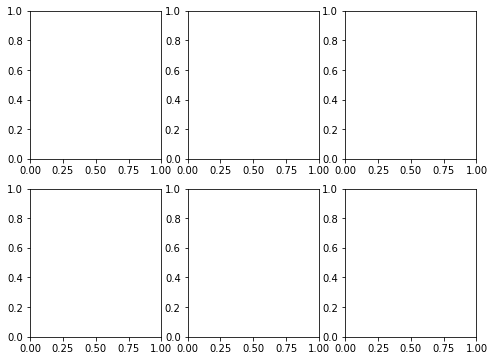

In [15]:
# TODO: use visualize_tensor to visualize the channel 0 of all convolutional layers and max-pooling layers of the first test image in MNIST
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(8, 6))

In [16]:
# ANSWER VERSION

def visualize_tensor(image, key, channel_idx, axis):
    """
    Visualize a tensor in the trained LeNet model.
    Args:
        image: a test image
        key: the key to the tensor in end_points
        channel_idx: index of the channel to be visualized
        axis: a pyplot Axis object
    """
    g = tf.Graph()
    with g.as_default():
        images = tf.placeholder(tf.float32, shape=[None, 784])
        labels = tf.placeholder(tf.float32, shape=[None, 10])
        keep_prob = tf.placeholder(tf.float32)
        logits, end_points = lenet(images, keep_prob)

        # Nodes for training
        loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)
        train = tf.train.AdadeltaOptimizer(1e-3).minimize(loss)

        # accuracy
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        saver = tf.train.Saver()
        with tf.Session(graph=g) as sess:
            saver.restore(sess, 'mnist_lenet_log/')
            
            # TODO: finish the line to get the tensor value of end_points[key]
            tensor_val = sess.run(end_points[key], feed_dict={images: [image], keep_prob: 1.0})
            
            # TODO: get the 2D image at channel "channel_idx"
            image_2d = tensor_val[0, :, :, channel_idx]
            
            # TODO: visualize
            axis.set_title(key)
            axis.imshow(image_2d, cmap='gray')

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Restoring parameters from mnist_lenet_log/
INFO:tensorflow:Restoring parameters from mnist_lenet_log/
INFO:tensorflow:Restoring parameters from mnist_lenet_log/
INFO:tensorflow:Restoring parameters from mnist_lenet_log/
INFO:tensorflow:Restoring parameters from mnist_lenet_log/


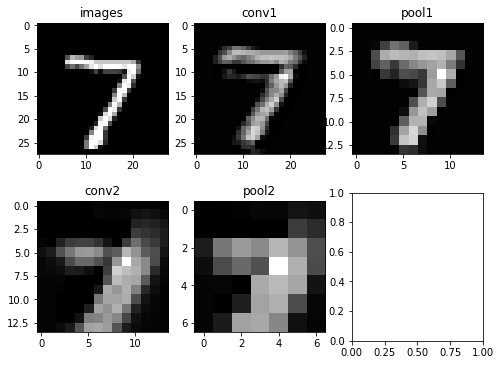

In [18]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("../data/MNIST_data/", one_hot=True)

# TODO: visualize image
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(8, 6))

visualize_tensor(mnist.test.images[0], 'images', 0, ax[0, 0])
visualize_tensor(mnist.test.images[0], 'conv1', 0, ax[0, 1])
visualize_tensor(mnist.test.images[0], 'pool1', 0, ax[0, 2])
visualize_tensor(mnist.test.images[0], 'conv2', 0, ax[1, 0])
visualize_tensor(mnist.test.images[0], 'pool2', 0, ax[1, 1])